In [98]:
# Hidden cell for imports

import galois
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Shamir Secret Sharing

Chapter 2 introduced additive secret sharing, a simple secret sharing scheme with an additive homomorphism. This chapter describes [*Shamir secret sharing*](todo), a *threshold sharing scheme*.

````{admonition} Further reading: Shamir Secret Sharing
:class: seealso

For more information on Shamir secret sharing, see [**Section 3.5 of The Joy of Cryptography**](https://joyofcryptography.com/ss/#sec.shamir).
````

## Threshold Secret Sharing Schemes

A *threshold secret sharing scheme* is similar to additive secret sharing, but with one major difference: it's possible to reconstruct the secret with *only a subset of the shares*. More formally, a threshold scheme is defined by two functions

- `share(x,t,n)` generates `n` secret shares with threshold `t` of the secret value `x`
- `reconstruct(ss)` decrypts a secret value from a list `ss` of `t` or more secret shares

Note the new parameter `t` (the threshold): when secret sharing a value, we can create as many shares as we like (by setting `n`), but when reconstructing, we can use any subset of size at least `t`.

Threshold schemes have useful applications in MPC and also in other contexts. For example, threshold schemes are often used to share values among multiple parties when it's likely that some of the parties could become unavailable during reconstruction (e.g. by losing their shares, or due to a network issue).

## The Shamir Scheme

The [Shamir secret sharing scheme](https://en.wikipedia.org/wiki/Shamir%27s_secret_sharing) is due to Adi Shamir {cite}`shamir1979share`. There are two key ideas behind the scheme:
- To secret share a value with threshold $t$, construct a [*polynomial* of degree $t$](todo)
- To reconstruct the secret from $t$ shares, use *polynomial interpolation*

This approach works because *any* $t$ points on a degree-$t$ polynomial are sufficient to reconstruct the polynomial. Fewer than $t$ points are insufficient to reconstruct the polynomial, so access to fewer than $t$ shares gives no information about the secret.

A polynomial of degree $t$ has the following form:

$$
f(x) = c_0 + c_1 x + c_2 x^2 + ... + c_t x^t
$$

In Shamir's scheme, the $y$-intercept $c_0$ encodes the secret, and the other coefficients $c_1, \dots, c_t$ are random. These polynomials work exactly like normal polynomials, except that we compute everything in a finite field $GF(p)$ (as usual!). That means all of the coefficients $c_0, \dots, c_t$ are in $GF(p)$, and when we compute an $x,y$ point on the polynomial, we do so with field arithmetic. This causes interesting results when we graph the polynomial - as we'll see, the polynomial will appear to "wrap around" in the graph, just like all arithmetic in a finite field.

The Galois library has some useful functions for working with polynomials. The following example shows the construction of a degree-2 polynomial with the coefficients 10 and 5 in the field $GF(97)$:

In [99]:
p = 97
GF = galois.GF(p)
coefficients = GF([10, 5])
poly = galois.Poly(coefficients)
poly

Poly(10x + 5, GF(97))

Once we have a `Poly` object, we can evaluate the polynomial at any value of $x$ to get the value of $y$ - for example, to graph the polynomial.

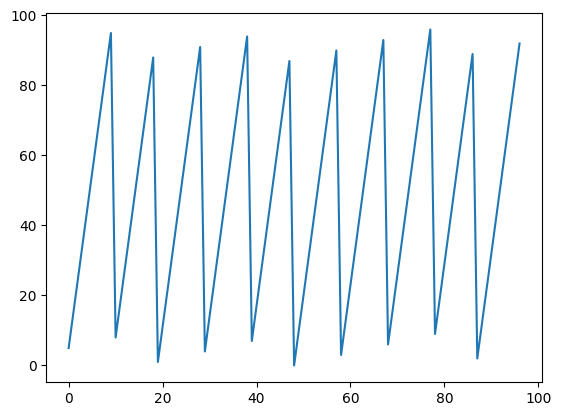

In [100]:
xs = GF(list(range(97)))
ys = [poly(x) for x in xs]
plt.plot(xs, ys);

Notice that the $y$ values never exceed $p$ - the polynomial "wraps around" back to 0 when it reaches $p$. Higher-degree polynomials tend to have even more interesting shapes:

Poly(10x^4 + 5x^3 + 38x^2 + 29x + 5, GF(97))

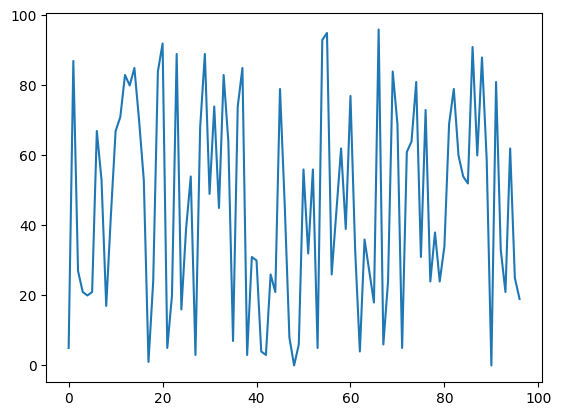

In [101]:
coefficients = GF([10, 5, 38, 29, 5])
poly = galois.Poly(coefficients)
xs = GF(list(range(97)))
ys = [poly(x) for x in xs]
plt.plot(xs, ys)
poly

### Constructing Shares

To construct $n$ shares of a secret with threshold $t$, we'll following these steps:
1. Choose $t-1$ random coefficients $c_1, \dots, c_t$
2. Construct a degree-$t$ polynomial $f(x)$ with coefficients $c_0, \dots, c_t$ where $c_0$ is the secret
3. The shares are $n$ $(x, y)$ pairs $(x_1, f(x_1)), \dots, (x_n, f(x_n))$ where $x_i > 0$

In the last step, it's common to pick $x_1 = 1, x_2 = 2, \dots, x_n = n$ for convenience. We can implement these steps in a function called `shamir_share`, and we'll also define a class to represent Shamir shares that stores their `x` and `y` values.

In [103]:
@dataclass
class ShamirShare:
    x: galois.GF
    y: galois.GF

def shamir_share(v, t, n):
    # Step 1: pick t-1 random coefficients
    coefficients = [GF.Random() for _ in range(t-1)]

    # Step 2: construct the polynomial
    coefficients.append(GF(v))
    poly = galois.Poly(GF(coefficients))

    # Step 3: compute the shares
    shares = [ShamirShare(GF(x), poly(GF(x))) for x in range(1, n+1)]
    return shares

In [104]:
shamir_share(GF(13), 2, 4)

[ShamirShare(x=GF(1, order=97), y=GF(77, order=97)),
 ShamirShare(x=GF(2, order=97), y=GF(44, order=97)),
 ShamirShare(x=GF(3, order=97), y=GF(11, order=97)),
 ShamirShare(x=GF(4, order=97), y=GF(75, order=97))]

### Reconstruction

Reconstruction is performed using [polynomial interpolation](https://en.wikipedia.org/wiki/Polynomial_interpolation). Given at least $t$ $(x,y)$ pairs on the polynomial, the interpolation process allows us to reconstruct the original polynomial. Since the coefficient $c_0$ is equal to the secret, knowing the polynomial is equivalent to knowing the secret. Reconstruction follows these steps:

1. Recover the original polynomial $f(x)$ using polynomial interpolation
2. Evaluate $f(0)$ to recover the secret

The Galois library provides a function called `lagrange_poly` for performing interpolation, which we can use to implement reconstruction for Shamir shares.

In [105]:
def shamir_reconstruct(shares):
    # Step 1: recover the polynomial
    xs = GF([s.x for s in shares])
    ys = GF([s.y for s in shares])
    poly = galois.lagrange_poly(xs, ys)

    # Step 2: evaluate f(0) to recover the secret
    secret = poly(0)
    return secret

In [106]:
shares = shamir_share(GF(13), 2, 4)
print('Reconstructed secret:', shamir_reconstruct(shares))

Reconstructed secret: 13


Now let's test the *threshold* part of Shamir sharing - since we set $t=2$, we should be able to reconstruct the secret using only 2 shares!

In [107]:
print('First two shares:', shares[0:2])
print('Reconstructed secret:', shamir_reconstruct(shares[0:2]))

First two shares: [ShamirShare(x=GF(1, order=97), y=GF(82, order=97)), ShamirShare(x=GF(2, order=97), y=GF(54, order=97))]
Reconstructed secret: 13


But we should *not* be able to reconstruct the secret with only a single share, and indeed we get a random result when we try:

In [108]:
print('First share:', shares[0:1])
print('Reconstructed secret:', shamir_reconstruct(shares[0:1]))

First share: [ShamirShare(x=GF(1, order=97), y=GF(82, order=97))]
Reconstructed secret: 82


## Adding Shamir Shares

Like additive shares, Shamir shares also have an additive homomorphism. It works because:
- Adding two polynomials is equivalent to adding their corresponding coefficients
- Since the coefficient $c_0$ represents the secret, adding two polynomials representing two different secrets results in a new polynomial whose $y$-intercept is the sum of the two secrets

Furthermore, it works on *shares* (in addition to the polynomials themselves) because:
- If $(x, y_1)$ lies on the polynomial $f_1$
- And $(x, y_2)$ lies on the polynomial $f_2$
- Then $(x, y_1 + y_2)$ lies on the polynomial $f_1 + f_2$

So, we can add Shamir-shared numbers together locally, just like we can with additive shares! Unlike with additive shares, we need to be careful *which* shares we add together when using Shamir shares - the added shares need to have the same $x$ coordinate. It's typical to assign each party in a protocol a particular $x$ coordinate and use the same one consistently throughout the protocol, so that each party always holds shares that are compatible.

In [110]:
class ShamirShare(ShamirShare):
    def __add__(self, other):
        assert self.x == other.x
        return ShamirShare(self.x, self.y + other.y)

shares1 = shamir_share(GF(13), 2, 4)
shares2 = shamir_share(GF(4), 2, 4)
result = [a + b for a, b in zip(shares1, shares2)]
print('Reconstructed sum:', shamir_reconstruct(result))

Reconstructed sum: 17


## Multiplying Shamir Shares

In addition to being a threshold scheme, Shamir secret sharing has a limited form of *multiplicative homomorphism*! To see why, consider the following two polynomials:

$$
\begin{align*}
f_1(x) &= 3 + 2x\\
f_2(x) &= 2 + 6x
\end{align*}
$$

Shares generated from these polynomials would represent the secrets 3 and 2, since those are the $y$-intercepts of the polynomials. What happens if we multiply these polynomials? Using basic algebra, we get:

$$
\begin{align*}
f(x) &= f_1(x) f_2(x) \\
&= 3*2 + 18x + 4x + 12x^2 \\
&= 6 + 22x + 12x^2
\end{align*}
$$

Look - the $y$-intercept is the *product of the two secrets*, as desired! There's only one problem: the *degree of the polynomial has increased*. That means we'll need more shares than before to reconstruct the secret, because the threshold depends on the degree of the polynomial.

In general, multiplying two polynomials of degree $d$ results in a polynomial of degree at most $2d$. This means we can multiply Shamir shares with threshold $t$ to get new Shamir shares of the product with threshold $2t$. Here, we multiply shares with $t=2$ and get new shares with $t=4$:

In [115]:
class ShamirShare(ShamirShare):
    def __mul__(self, other):
        assert self.x == other.x
        return ShamirShare(self.x, self.y * other.y)

shares1 = shamir_share(GF(13), 2, 4)
shares2 = shamir_share(GF(4), 2, 4)
result = [a*b for a, b in zip(shares1, shares2)]
print('Reconstructed product:', shamir_reconstruct(result))

Reconstructed product: 52


However, note that we now need more than 2 shares to reconstruct, since the threshold has gone up. When we try to reconstruct with only 2 shares, we get a random result.

In [116]:
print('Reconstructed product, with only 2 shares:', shamir_reconstruct(result[0:2]))

Reconstructed product, with only 2 shares: 47


This limited form of multiplicative homomorphism provides a great starting point for building MPC protocols that perform multiplication using Shamir shares, by shifting the problem of multiplication to one of reducing the degree of the resulting polynomial.